![meme](https://i.imgflip.com/6x0g1f.jpg)

# Optimizing fantasy basketball

Fantasy basketball is an extremely popular pasttime for nba fans. Participants 'draft' players before the season, then get rewarded for their proxy's in-game performances during the season. 

One popular format is 'Head-to-Head: Most Categories'. Quoting from ESPN's description of the rules:

>Head-to-Head: Most Categories: H2H Most Categories allows you to set "X" number of statistic categories. For each scoring period (usually Monday through Sunday) team totals are accumulated in each of the categories. At the end of the scoring period, the winner is determined by which team wins the most number of categories. The end result is a win (1-0-0), loss (0-1-0) or tie (0-0-1). These results correspond directly to each team's overall record.

Common settings specify 9 categories: points, rebounds, assists, steals, blocks, 3-pointers, field goal %, free throw %, and turnovers. We'll ignore the percentage statistics for now, since they behave differently than the others

Participants are paired up to compete week-by-week, and at the end of the season, the player with the best record wins.

Understanding the game of basketball helps win fantasy drafts. However, it's not the whole ballgame: even if we had precise probability distributions for player performance beforehand, or exact numbers with no uncertainty, it would not be obvious how to draft correctly. Do we want to optimize for all 9 categories, or just some of them? Do we try to compete on the categories that other drafters are going for, or ones they are not? Do we embrace high-volatility players or low-volatility players? The problem becomes a rich mathematical one, more familiar to data scientists than to basketball enthusiasts

There is plenty of speculation about all this within the fantasy basketball community. However, few in the community realize that their strategies are leveraging high-level mathematical intuition. If we lean into the math, and treat this as an optimization problem, can we derive a method for fantasy drafting that delivers consistently high performance?

Our approach will be to break down the drafting problem into three mathematical steps
- Retrospectively drafting a full previous season, with full knowledge of player performance. Weekly totals will be randomly sampled from actual weekly totals for each player. Fantasy drafting this way becomes a full-information game, and therefore at least one Nash equilibrium exists. We will explore different ways of looking for it 
- Incorporating uncertainty into the priors of restrospective-drafting. We will explore how the strategy for retrospective drafting changes when there is uncertainty about the underlying probability distributions of player statistics
- Using predictive data science methods to make estimates of priors/posteriors for actual performance. This last step will allow us to design an actual drafting algorithm that could be used for a season of fantasy basketball

One other note, before we get started:

NBA fantasy drafts require participants to play with a certain number of players at each position, e.g. 3 centers, plus a few players on the bench who do not count. I've personally found in my (albeit limited) experience that usually I can have all of my players and games count by shifting players to the bench when they are not playing. This would not be the case if my team was totally imbalanced and for example had no centers, but otherwise I think it is a fair assumption. Therefore I will simplify the problem in the following way: 

- Each team must have 3 centers, 1 point guard, 1 shooting guard, 2 guards (either PG or SG), 1 small forward, 1 power forward, 2 forwards (either SF or PF), and 3 utilities (any positions)
- Every game that your players play counts towards your totals

# Retrospective drafting

Let's lay out the infrastructure for the first step, retrospective drafting

In [1309]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from itertools import combinations
from collections import Counter
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import copy
from scipy import special
import cvxpy
from unidecode import unidecode
pd.set_option('display.max_rows', 150)
pd.options.mode.chained_assignment = None  # default='warn'

We will use the raw data from [Advanced Sports Analytics](https://www.advancedsportsanalytics.com/nba-raw-data), which has game-by-game player statistics

In [974]:
stat_df = pd.read_csv('../data/ASA All NBA Raw Data.csv')
essential_info = stat_df[['player','game_date','pts','trb','ast','stl','blk','fg3','fg','fga','ft','fta','tov']]
sum_categories = ['pts', 'trb', 'ast', 'stl', 'blk', 'fg3','tov']
categories = sum_categories + ['fg_pct','ft_pct']

player position data is from [data.world](https://data.world/etocco/nba-player-stats)

In [1311]:
player_data = pd.read_csv('../data/NBA_Player_Stats_2.csv')
rel_player_data = player_data[(player_data['Season'] == '2021-22') & (player_data['Pos'].isin(['C','SG','PG','PF','SF'])) ]
positions = rel_player_data[['Player','Pos']].drop_duplicates().groupby('Player')['Pos'].apply(list)
positions.index = [unidecode(player) for player in positions.index]
#first approach: keep track of which positions you have room for. don't take a player if you cant fit them. Use this for 
#all the drafters, naive to smart

The most important infrastructure is code simulating an actual NBA fantasy season, so that we can evaluate the success of our strategies. Actually, since our model is probabilistic, we want to run many seasons and get the average # of wins

In [975]:
essential_info['game_date'] = pd.to_datetime(essential_info['game_date'])
essential_info_2021_season = essential_info[(essential_info['game_date'] >= '2021-10-19') &  \
                                            (essential_info['game_date'] <= '2022-4-10')]
essential_info_2021_season['week'] = essential_info['game_date'].dt.isocalendar()['week']

weekly_df_index = pd.MultiIndex.from_product([pd.unique(essential_info_2021_season['player'])
                                             ,pd.unique(essential_info_2021_season['week'])]
                                             ,names = ['player','week'])
weekly_df_2021_season = essential_info_2021_season.drop(columns = ['game_date']).groupby(['player','week']).sum()
weekly_df_2021_season = pd.DataFrame(weekly_df_2021_season, index = weekly_df_index ).fillna(0)

In [960]:
def run_multiple_seasons(teams
                         , n = 100 
                         , detailed = False):
    #create a version of the essential info dataframe which incorporate team information for this season
    season_df = weekly_df_2021_season.reset_index().drop(columns = 'week')
    season_df.loc[:,'team'] = season_df['player'].map(teams) 
    season_df = season_df.dropna(subset = ['team'])

    #use sampling to simulate many seasons at the same time
    #assuming each season has 11 weeks, we need 11 * n total rows of data per player
    #ZR: Note that for now a "week" of data is just one game per player
    #in real basketball multiple games are played per week, so we need to adjust for that 
    performances = season_df.groupby('player').sample(25*n, replace = True)
    performances.loc[:,'week'] = performances.groupby('player').cumcount()
    performances.loc[:,'season'] = performances['week'] // 25 #integer division seperates weeks in groups 

    #total team performances are simply the sum of statistics for each player 
    team_performances = performances.groupby(['season','team','week']).sum()
    team_performances['fg_pct'] = (team_performances['fg']/team_performances['fga']).fillna(0)
    team_performances['ft_pct'] = (team_performances['ft']/team_performances['fta']).fillna(0)
    
    #for all categories except turnovers, higher numbers are better. So we invert turnovers 
    team_performances['tov'] = - team_performances['tov'] 
    
    team_performances = team_performances[categories] #only want category columns
    
    #we need to map each team to its opponent for the week. We do that with a formula for round robin pairing
    opposing_team_schedule = [(s,round_robin_opponent(t,w),w) for s, t, w in team_performances.index]
    opposing_team_performances = team_performances.loc[opposing_team_schedule]

    cat_losses = np.less(team_performances.values,opposing_team_performances.values).sum(axis = 1)
    cat_wins = np.greater(team_performances.values,opposing_team_performances.values).sum(axis = 1)
    
    #print(pd.DataFrame(np.greater(team_performances.values,opposing_team_performances.values)
    #                   , columns = categories
    #                   , index = team_performances.index).groupby('team').mean())

    team_performances.loc[:,'tie'] = cat_wins == cat_losses
    team_performances.loc[:,'win'] = cat_wins > cat_losses
    team_results = team_performances.groupby(['team','season']).agg({'win' : sum, 'tie' : sum})

    #a team cannot win the season if it has fewer wins than any other team 
    most_wins = team_results.groupby('season')['win'].transform('max')
    winners = team_results[team_results['win'] == most_wins]

    #among the teams with the most wins, ties are a tiebreaker 
    most_ties = winners.groupby('season')['tie'].transform('max')
    winners_after_ties = winners[winners['tie'] == most_ties]
    
    #assuming that payouts are divided when multiple teams are exactly tied, we give fractional points 
    winners_after_ties.loc[:,'winner_points'] = 1
    season_counts = winners_after_ties.groupby('season')['winner_points'].transform('count')
    winners_after_ties.loc[:,'winner_points_adjusted'] = 1/season_counts
    
    if not detailed:
        return winners_after_ties.groupby('team')['winner_points_adjusted'].sum()
    else:
        return winners_after_ties.groupby('team')['winner_points_adjusted'].sum(), team_performances, opposing_team_performances

We invoked a helper function above, "round_robin_opponent", without defining it. We need it to assign sensible pairings between competitors. Using [Wikipedia's algorithm for pairing a round robin](https://en.wikipedia.org/wiki/Round-robin_tournament#Circle_method) we can make this work via modular arithmetic

In [961]:
def round_robin_opponent(t
                         , w
                         , n =12): # n must be an even number
    
    if t == 0: #position 0 remains fixed, and the other teams rotate around their (n - 1) spots
        return ((n - 2 - w) % (n - 1) ) + 1
    elif ((t + w) % (n-1) ==0): # in spot (n-1) of the non-zero spots, the opponent is 0 
        return 0 
    else: #we calculate the current position of team, infer the opponent's position, then calculate the opposing team
        res = (((n - 1 - (t + w) % (n - 1)) % (n - 1))- w) % (n - 1)
        return (n - 1) if res == 0 else res
         

Now we also need to set up the drafting process. A simple drafter will use player stat totals, so we will create a table for them

Simple drafting agents will choose the top available player based on this table with some kind of scaling/weighting of categories

Drafts are typically run in the snake format. We'll consider a single round to be the back and forth of the snake- so for example with three drafters, player one picks, player two picks, player three picks two players, player two picks, and player one picks

In [962]:
def run_draft(agents, number_of_rounds):
    
    player_assignments = {}
    
    for i in range(number_of_rounds):
        for j in range(len(agents)):
            
            agent = agents[j]
            chosen_player = agent.make_pick(player_assignments)
            player_assignments[chosen_player] = j
            
        for j in reversed(range(len(agents))):
            agent = agents[j]
            chosen_player = agent.make_pick(player_assignments)
            player_assignments[chosen_player] = j

    return player_assignments

When we test a strategy, we want to see if it works broadly, not just in any one position. So we will create a helper function that tries a strategy in each position against some default agent in all the other positions

In [963]:
def try_strategy(primary_agent, default_agent, n_seasons):

    strategy_res = [[] for i in range(12)]
    #teams_selected = [[] for i in range(12)]
    for i in range(12):
        #we need to deepcopy the agents so that they don't share references with each other
        agents = [copy.deepcopy(default_agent).set_draft_number(x) for x in range(i)] + \
                    [copy.deepcopy(primary_agent).set_draft_number(i)] + \
                    [copy.deepcopy(default_agent).set_draft_number(i + x + 1) for x in range(11-i)]
        
        teams = run_draft(agents ,7)
        #teams_selected[i] = [k for k,v in teams.items() if v == i]
        res = run_multiple_seasons(teams, n_seasons)
        strategy_res[i] = (res.get(i)) if (res.get(i)) is not None else 0 
        
    return np.sum(strategy_res)/(12*n_seasons)


## 1a. Z-scores

Fantasy rankings are often made by summing players' z-scores (this means exactly the same thing as it does in statistics, the # of standard deviations away from the mean) by category. We can use this methodology as a naive baselines for player rankings. Since many real drafters use z-scores, we can expect that the strategies that work the best against z-scores will do the best in practice. 

Normally, z-scores are calculated based on the league average. This is slightly odd because most league players never get used in fantasy drafts, and shouldn't influence our way of thinking about relevant players. Perhaps we can improve on the basic z-score methodology by re-scaling with only the top players

In [1162]:
player_averages = weekly_df_2021_season.reset_index().drop(columns= 'week').groupby('player').mean()
player_averages['fg_pct'] = (player_averages['fg']/player_averages['fga']).fillna(0)
player_averages['ft_pct'] = (player_averages['ft']/player_averages['fta']).fillna(0)
player_averages = player_averages.drop(columns = ['ft','fta','fg','fga'])
player_averages = player_averages[categories]

In [1222]:
my_players = ['LaMelo Ball','LeBron James']
positions.loc[my_players]

Player
LaMelo Ball     [PG]
LeBron James    [SF]
Name: Pos, dtype: object

In [1292]:

def check_team_feasability(players):    
    n_players = len(players)
    X = cvxpy.Variable(shape = (n_players,8))

    eligibility = np.concatenate([get_eligibility_row(player) for player in players])
        
    one_position_constraint = cvxpy.sum(X,axis = 1) == 1
    available_positions_constraint = cvxpy.sum(X,axis = 0) <= [3,1,1,2,1,1,2,2]    
    eligibility_constraint = X <= eligibility    
    constraints = [one_position_constraint, available_positions_constraint, eligibility_constraint]
    
    problem = cvxpy.Problem(cvxpy.Minimize(0), constraints)
    problem.solve()
    
    return not problem.status == "infeasible"

#use this to make a more refined version of the positions df 
def get_eligibility_row(pos):
    eligibility = {7}
    if 'C' in pos:
        eligibility.add(0)
    if 'PG' in pos: 
        eligibility.update((1,3))
    if 'SG' in pos: 
        eligibility.update((2,3))
    if 'SF' in pos: 
        eligibility.update((4,6))
    if 'PF' in pos: 
        eligibility.update((5,6))
    return np.array([[i in eligibility for i in range(8)]])


In [1296]:
check_team_feasability([['C'],['C'],['C'],['C'],['C'],['C']])

False

In [1276]:
x = np.array([[True, True, True]])
np.concatenate([x,x])

array([[ True,  True,  True],
       [ True,  True,  True]])

In [1314]:
class z_score_agent():
    
    def __init__(self
                 , punting_cats =[] #categories to completely ignore
                 ):
        
        player_averages_scaled = pd.DataFrame(StandardScaler().fit_transform(player_averages)
                                            , index = player_averages.index
                                            ,columns = player_averages.columns)
        player_averages_scaled['tov'] = - player_averages_scaled['tov']
                
        self.order = player_averages_scaled.drop(columns = punting_cats).sum(axis = 1).sort_values(ascending = False)
        self.players = []

    def make_pick(self, player_assignments):
        
        available_players = self.order[~self.order.index.isin(player_assignments.keys())]
        
        if len(self.players) < 5:
            player = self.order.index[0]
            self.players = self.players + [player]
            return player
        
        else:
            for player in available_players.index:
                theoretical_team = self.players + [player]

                if check_team_feasability(positions[theoretical_team]):
                    self.players = theoretical_team
                    return player
            raise ValueError('No available players!')
    
    def set_draft_number(self, draft_number):
        return self #doesn't use draft number
    
class z_plus_agent():
    
    def __init__(self
                 , punting_cats =[] #categories to completely ignore
                 ,n_players = 12*7*2
                 ):
        
        first_order_scaled = pd.DataFrame(StandardScaler().fit_transform(player_averages)
                                            , index = player_averages.index
                                            ,columns = player_averages.columns)
        first_order_scaled['tov'] = - first_order_scaled['tov']
        
        first_order = first_order_scaled.drop(columns = punting_cats).sum(axis = 1).sort_values(ascending = False)
        top_players = first_order.index[0:n_players]
        
        plus_scaler = StandardScaler().fit(player_averages.loc[top_players])
        
        second_order_scaled = pd.DataFrame(plus_scaler.transform(player_averages)
                                            , index = player_averages.index
                                            ,columns = player_averages.columns)
        second_order_scaled['tov'] = - second_order_scaled['tov']
        
        self.order = second_order_scaled.drop(columns = punting_cats).sum(axis = 1).sort_values(ascending = False)
        self.players = []

    def make_pick(self, player_assignments):
        
        available_players = self.order[~self.order.index.isin(player_assignments.keys())]
        
        if len(self.players) < 5:
            player = self.order.index[0]
            self.players = self.players + [player]
            return player
        
        else:
            for player in available_players.index:
                theoretical_team = self.players + [player]

                if check_team_feasability(positions[theoretical_team]):
                    self.players = theoretical_team
                    return player
            raise ValueError('No available players!')
    
    def set_draft_number(self, draft_number):
        return self #doesn't use draft number

In [1315]:
start = datetime.now()
primary_agent = z_plus_agent(n_players = 12*7*2)
default_agent = z_score_agent()
res = try_strategy(primary_agent, default_agent, 1000)
print(res)
print(datetime.now() - start)

KeyError: "['Deandre Ayton'] not in index"

In [1317]:
[x for x in positions.index if 'Dean' in x]

['Dean Wade']

In [1318]:
positions

Aaron Gordon       [PF]
Aaron Henry        [SF]
Aaron Holiday      [PG]
Aaron Nesmith      [SF]
Aaron Wiggins      [SG]
                   ... 
Zach LaVine        [SF]
Zavier Simpson     [PG]
Zeke Nnaji         [PF]
Ziaire Williams    [SF]
Zylan Cheatham     [SF]
Name: Pos, Length: 599, dtype: object

It seems like this does work considerably better than the baseline! 

## 1b. The Gaussian optimizer 

To start designing a more sophisticated algorithm, let's analyze the points we'll score in a category, and the points an opponent will score in the same category. Where $F_{pc}$ is the number of points scored by player $p$ in category $c$, we can write them as 

$$
  \sum_{p \in T_0} F_{pc} \quad , \quad \sum_{p \in T_1} F_{pc}
$$

The point differential between the two is

$$
  \sum_{p \in T_1} F_{pc} +  \sum_{p \in T_0} - F_{pc}
$$

With 14 players per team, the point differential is a sum of 28 random variables. That is large enough that it is not crazy to invoke the law of large numbers, which simplifies the distribution to a normal distribution. Writing $m_{pc}$ as the mean of a player $p$'s category $c$ statistics, and $\sigma_{pc}$ as the corresponding standard deviation, we get it as 

$$
   N(\sum_{p \in T_0} m_{pc} - \sum_{p \in T_1} m_{pc} \: , \: \sum_{p \in T_0} \sigma_{pc}^2 + \sum_{p \in T_1} \sigma_{pc}^2)
$$

The CDF of this normal distribution at 0, which also represents the probability of victory, is 

$$
   \frac{1}{2}[1 + erf(\frac{\sum_{p \in T_0} m_{pc} - \sum_{p \in T_1} m_{pc}}{\sqrt{2 (\sum_{p \in T_1} \sigma_{pc}^2 + \sum_{p \in T_0} \sigma_{pc}^2)}}]
$$

There is one significant wrinkle- free throw percentage and field goal percentage do not work like the other categories, since they are the result of division between two statistics. We can model them a different way. Assuming that each player shoots their average number of shots per game, and their overall percentage is constant throughout the season, then the percentage categories become a sum of binomials (or a Poisson binomial) divided by the number of free throw attempts. The mean of a Poisson binomial is simply the overall weighted mean. The variance of a Poisson binomials is the sum of variance of bernoullis, which can be written as, for example

$$
    \sum_{p \in T} \frac{FT_p}{FTA_p} * (1-\frac{FT_p}{FTA_p}) * FTA_p
$$

or rearranged

$$
    \sum_{p \in T} \frac{FT_p}{FTA_p} * (FTA_p-FT_p)
$$

To get the correct variance for the overall percentage statistic, we need to adjust for the division. Variance changes by the square of a change factor so the result is 

$$
    \frac{ \sum_{p \in T} \frac{FT_p}{FTA_p} * (FTA_p-FT_p)} {(\sum_{p \in T} FTA_p)^2}
$$

This gives us an overall formula for the probability of winning every category. The distribution of the total categories won is then another Poisson binomial, where the component binomials are all categories with the same winning probabilities. unfortunately the Poisson binomial has a CDF involving quite a bit of calculation- there is just no way to simplify the function besides enumerating all possibilities. Fortunately, the number of winning scenarios is only 
$$
    {9 \choose 5} + {9 \choose 6} + {9 \choose 7} + {9 \choose 8}  + {9 \choose 9} = 256
$$

So we can manually check each way of winning the match (for example, winning points/rebounds/assists/steals and losing the others), calculate their probabilities, and add them together.

This gives us a formula, albeit a complicated one, to calculate the predicted win probability between two teams. We can use it to pick player with the following process:
1. Define the statistics of a representative opposing team, or multiple opposing teams
2. For each player you could draft, calculate your team's statistics if you chose that player
3. For every possibility from step 2, calculate your probability of winning against the team(s) from part 1
4. Choose the player who gives you the best chance of winning




One might argue that the procedure defined above is too greedy because it optimizes winning chances at each step, ignoring players' general value. Ideally we want the optimizer to start by looking at players' general value (total z_plus score), then find players that best fit the team in later rounds. One strategy for this is to make a hybrid score, consisting of both the Gaussian win probability and the z_plus score. Since z_plus scores tend to be larger than win probabilities, we need to include a parameter to de-weight them, which we will call beta. We can also weigh the z score in a dynamic way, decreasing its importance from 100% to 0% by the last round.

In [1151]:
def process_stat_df(stat_df):
    stat_df = pd.concat([stat_df, pd.DataFrame(columns = pd.MultiIndex.from_product([["fg_pct", "ft_pct"], ["mean", "var"]])
                                              , index = stat_df.index)], axis = 1)
                           
    stat_df.loc[:,('fg_pct','mean')] = stat_df.loc[:,('fg','mean')]/stat_df.loc[:,('fga','mean')]
    stat_df.loc[:,('fg_pct','var')] = stat_df['fg_var']/(stat_df.loc[:,('fga','mean')]**2)

    stat_df.loc[:,('ft_pct','mean')] = stat_df.loc[:,('ft','mean')]/stat_df.loc[:,('fta','mean')]
    stat_df.loc[:,('ft_pct','var')] = stat_df['ft_var']/(stat_df.loc[:,('fta','mean')]**2)
    
    stat_df.loc[:,('tov','mean')] = - stat_df.loc[:,('tov','mean')]
    stat_df = stat_df[categories]
    stat_df.sort_index(axis=1, inplace = True)
    return stat_df

class hybrid_gaussian_optimizer_agent():
    

    def __init__(self, punting_cats= [], beta = 0):
               
        self.punting_cats = punting_cats
        #make a table with player averages + standard deviations as additional columns 
        player_stats = weekly_df_2021_season.groupby(level = 'player').agg(['mean','var'])
        
        #it is helpful to keep track of the variance contribution of fg_pct and ft_pct
        fg = player_stats.loc[:, ('fg','mean')]
        fga = player_stats.loc[:, ('fga','mean')]
        player_stats.loc[:,'fg_var'] = fg/fga *(fga - fg)
        
        ft = player_stats.loc[:, ('ft','mean')]
        fta = player_stats.loc[:, ('fta','mean')]
        player_stats.loc[:,'ft_var'] = ft/fta *(fta - ft)  
        
        self.player_stats = player_stats
        #since we want to beat teams that use simple z-scores, we'll use them as representative opponents
        representative_teams = run_draft([z_score_agent() for x in range(12)] ,7)
        
        self.team_list = [[] for i in range(12)]
        for k,v, in representative_teams.items():
            self.team_list[v].append(k) 
                
        #for our own z_score estimates we want the best possible values, so we use z_plus
        self.z_scores = z_plus_agent(punting_cats = punting_cats).order * beta
                        
    def make_pick(self, player_assignments):
        
        my_players = [k for k,v in player_assignments.items() if v == self.draft_number]
        round_n = len(my_players) 
        
        #1. Get the theoretical stats that your team will have, depending on which player you choose
        my_team_stats = self.player_stats.loc[my_players]
        available_players = self.player_stats.loc[~self.player_stats.index.isin(player_assignments.keys())]
        theoretical_stats = available_players + my_team_stats.sum()
        theoretical_stats = process_stat_df(theoretical_stats)
        
        #grab the representative teams that were saved earlier
        other_teams = [x[:round_n + 1] for x in self.team_list]
        other_team_stats = pd.DataFrame(
            {i : self.player_stats.loc[self.player_stats.index.isin(other_teams[i])].agg('sum') for i in range(12)}
                                        ).T
        other_team_stats = process_stat_df(other_team_stats)
        
        #a cross join gives us a row for all of our players by each representative team
        full_stat_df = theoretical_stats.reset_index().merge(other_team_stats
                                                             , how = 'cross'
                                                             , suffixes = ['_my','_other'])


        
        #with all the statistical parameters incolved, we can get probabilities of winning each category
        my_stat_cols = [c + '_my' for c in categories]
        other_stat_cols = [c + '_other' for c in categories]

        my_means = full_stat_df.loc[:,(my_stat_cols,'mean')].values
        other_means = full_stat_df.loc[:,(other_stat_cols,'mean')].values

        my_vars = full_stat_df.loc[:,(my_stat_cols,'var')].values
        other_vars = full_stat_df.loc[:,(other_stat_cols,'var')].values
        
        with np.errstate(invalid='ignore', divide='ignore'):
            z = np.where((my_vars + other_vars) > 0 
                                         , (my_means - other_means)/(np.sqrt(2 * (my_vars + other_vars)))
                                         , 0)

        c = pd.DataFrame((1 + special.erf(z))/2, columns = categories)
        c[self.punting_cats] = 0
        c_comp = 1 - c

        #the combinatorial calculation function computes the Poisson binomial cdf efficiently
        full_stat_df.loc[:,'win_probability'] = combinatorial_calculation(c, c_comp)
        
        #the best player will roughly have the highest EV of winning against the other players
        player_scores = full_stat_df.groupby('player')['win_probability'].sum()
        
        #adjust the Gaussian optimizer's score with the saved z-scores
        player_scores_adjusted = player_scores * (round_n)/13 + self.z_scores * (13-round_n)/13
        chosen_player = player_scores_adjusted.idxmax()
        return(chosen_player)
    
    def set_draft_number(self, draft_number):
        self.draft_number = draft_number
        return self      

In [1177]:
def try_beta_strategy(beta, n = 500):
    primary_agent = hybrid_gaussian_optimizer_agent(punting_cats = [], beta = beta)
    default_agent = z_score_agent(punting_cats = [])
    res = try_strategy(primary_agent, default_agent, n)
    variance = np.sqrt(res*(1-res)/(12 * n))
    return res, variance

start = datetime.now()
beta_results = {beta : try_beta_strategy([beta]) for beta in [0,0.05,0.1,0.15,0.2]}
print(datetime.now() - start)

0:04:33.895500


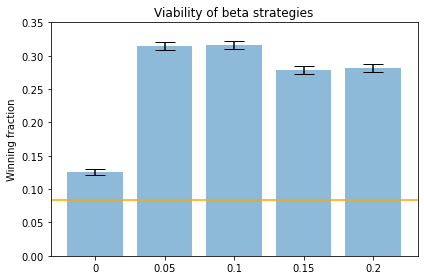

In [1178]:
results_unpacked = list(map(list,zip(*[(str(x[0]),x[1][0],x[1][1]) for x in beta_results.items()])))

fig, ax = plt.subplots()

x_pos = np.arange(len(results_unpacked[0]))
ax.bar(x_pos
       , results_unpacked[1]
       , yerr=results_unpacked[2]
       , align='center'
       , alpha=0.5
       , ecolor='black'
       , capsize=10)

ax.set_ylabel('Winning fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_unpacked[0])
ax.set_title('Viability of beta strategies')
ax.axhline(y=1/12, color='orange', linestyle='-')
ax.set_ylim([0, 0.35])

# Save the figure and show
plt.tight_layout()
plt.show()

We can see a local optimum around beta = 0.1 which is above 30%! That is quite a bit better than the z_plus score, and much better than the simpler z score

## 1b. Optimization through punting

There is one more common strategy that we should consider: punting. Many fantasy drafters choose to ignore some number of categories in order to improve their performance in the other categories. We will test this to see if it gives our methodology a boost

In [967]:
def try_punting_strategy(punting_cats, n = 500):
    primary_agent = z_plus_agent(punting_cats = punting_cats)
    default_agent = z_score_agent(punting_cats = [])
    res = try_strategy(primary_agent, default_agent, n)
    variance = np.sqrt(res*(1-res)/(12 * n))
    return res, variance

In [968]:
start = datetime.now()
punting_results = {cat : try_punting_strategy([cat]) for cat in categories}
print(datetime.now() - start)

0:04:18.497917


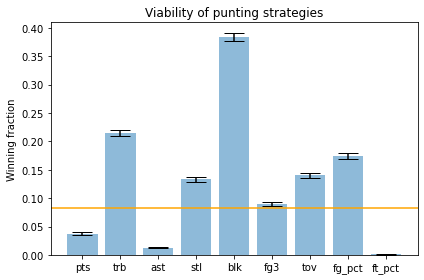

In [976]:
results_unpacked = list(map(list,zip(*[(x[0],x[1][0],x[1][1]) for x in punting_results.items()])))

fig, ax = plt.subplots()

x_pos = np.arange(len(results_unpacked[0]))
ax.bar(x_pos
       , results_unpacked[1]
       , yerr=results_unpacked[2]
       , align='center'
       , alpha=0.5
       , ecolor='black'
       , capsize=10)

ax.set_ylabel('Winning fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_unpacked[0])
ax.set_title('Viability of punting strategies')
ax.axhline(y=1/12, color='orange', linestyle='-')

# Save the figure and show
plt.tight_layout()
plt.show()

Punting blocks apparently is a great idea in theory. That makes some sense, because most players that get a lot of blocks have poor stats in other areas

In practice, punting blocks can be very hard because usually every team is required to have some number of centers, who tend to have many blocks. For now we will try to do the best we can without punting any categories

Need to figure out how to incorporate 